In [13]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import torch
import config as cfg
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools import regressors, feature_selectors
from utility.builder import Builder
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lifelines.statistics import proportional_hazard_test
from tools.evaluator import LifelinesEvaluator
from tools.Evaluations.util import predict_median_survival_time
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import config as cfg
import matplotlib.patheffects as path_effects
from sklearn.preprocessing import StandardScaler
from tools.formatter import Formatter
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import make_event_times

global DATASET
global N_BEARING
global TEST_SIZE
global TRAIN_SIZE
global N_SPLITS
global N_CONDITION    
global TYPE
global MERGE
global CENSORING
global N_BOOT

NEW_DATASET = False
DATASET = "xjtu"
TYPE = "not_correlated"  # not_correlated
CONDITION_SELECTOR = 0 # 0, 1, 2
PERCENTAGE = 0.1
TEST_SIZE = 0.3
N_CONDITION = len(cfg.RAW_DATA_PATH_XJTU)

if TYPE == "bootstrap":
    N_BOOT = 8
    cfg.DATA_TYPE = "bootstrap"
else:
    N_BOOT = 3
    cfg.DATA_TYPE = "not_bootstrap"

data_path = cfg.RAW_DATA_PATH_XJTU
N_CONDITION = len(data_path)
N_BEARING = cfg.N_REAL_BEARING_XJTU
N_SPLITS = 5
TRAIN_SIZE = 1
CENSORING = cfg.CENSORING_LEVEL

In [14]:
#For the first time running, a NEW_DATASET is needed
if NEW_DATASET== True:
    Builder(DATASET, N_BOOT).build_new_dataset(bootstrap=N_BOOT)

In [15]:
survival = Survival()
data_util = DataETL(DATASET, N_BOOT)

#Extract information from the dataset selected from the config file
cov_group = []
boot_group = []
info_group = []
for test_cond in range (0, N_CONDITION):
    cov, boot, info_pack = FileReader(DATASET).read_data(test_cond, N_BOOT)
    cov_group.append(cov)
    boot_group.append(boot)
    info_group.append(info_pack)

#Transform information from the dataset selected from the config file
data_container_X = []
data_container_y= []
for test_cond, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
    # Create different data for bootstrap and not bootstrap
    if TYPE == "bootstrap":
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_bootstrap(cov, boot, info_pack, N_BOOT)
    else:
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_upsampling(cov, boot, info_pack, N_BOOT, TYPE)
    data_container_X.append(data_temp_X)
    data_container_y.append(deltaref_temp_y)

#Load information from the dataset selected in the config file
X = data_container_X[CONDITION_SELECTOR]
y = data_container_y[CONDITION_SELECTOR]

#Information about the event estimation in event detector
y_delta = y
print ("The event detector established an event for each bearing at:", y_delta)

data_X = []
for data_group in X:   
    data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
    data_X.append(data_temp_X)
X = data_X

#Indexing the dataset to avoid train/test leaking
bearing_idx = list(range(0, N_BEARING))

#Test/train split
train_idx, test_idx, _, _= train_test_split(bearing_idx, bearing_idx, shuffle=False, test_size=TEST_SIZE, random_state=None)
data_X_merge_tr = pd.DataFrame()
data_X_merge_te = pd.DataFrame()
for element in train_idx:
    data_X_merge_tr = pd.concat([data_X_merge_tr, X[element]], ignore_index=True)
for element in test_idx:
    data_X_merge_te = pd.concat([data_X_merge_te, X[element]], ignore_index=True)
    
# Format data
X_train = data_X_merge_tr.drop(['Event', 'Survival_time'], axis=1)
X_test = data_X_merge_te.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", data_X_merge_tr)
y_test = Surv.from_dataframe("Event", "Survival_time", data_X_merge_te)
features = list(X_train.columns)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = feature_selectors.PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

# Scale train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=best_features)
X_train_scaled.reset_index(inplace=True, drop=True)

For bearing #21, event considered at the end of the recording
For bearing #31, event considered at the end of the recording
For bearing #11, event considered at the end of the recording
The event detector established an event for each bearing at: {1: 70.0, 11: 50.0, 21: 140.0, 31: 110.0, 41: 10.0}


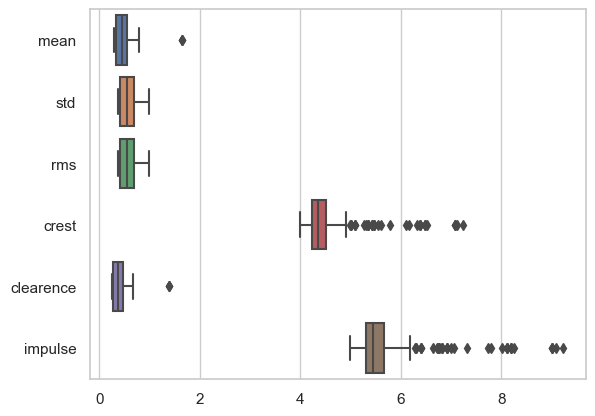

In [ ]:
# Plot test data
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
sns.set()
sns.set_style("whitegrid")
sns.boxplot(data=X_test, orient= "h") # notch=True
plt.show()

100%|██████████| 1/1 [00:00<00:00, 166.64it/s]


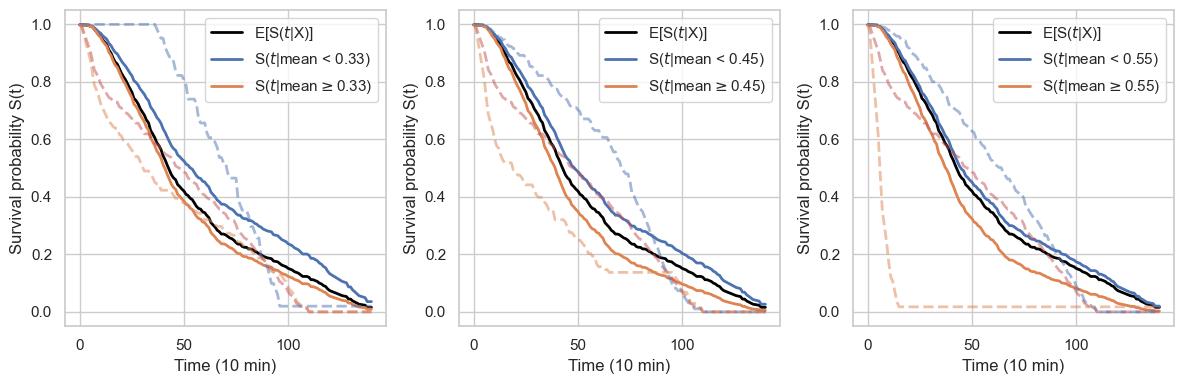

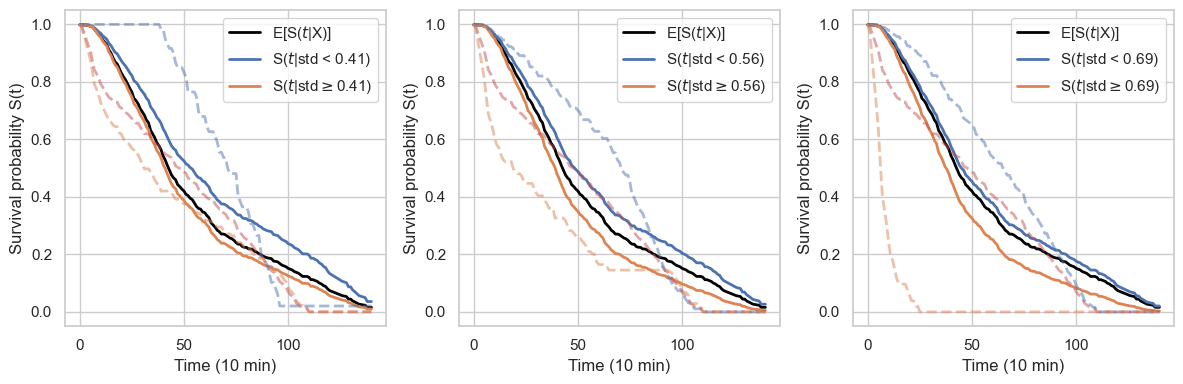

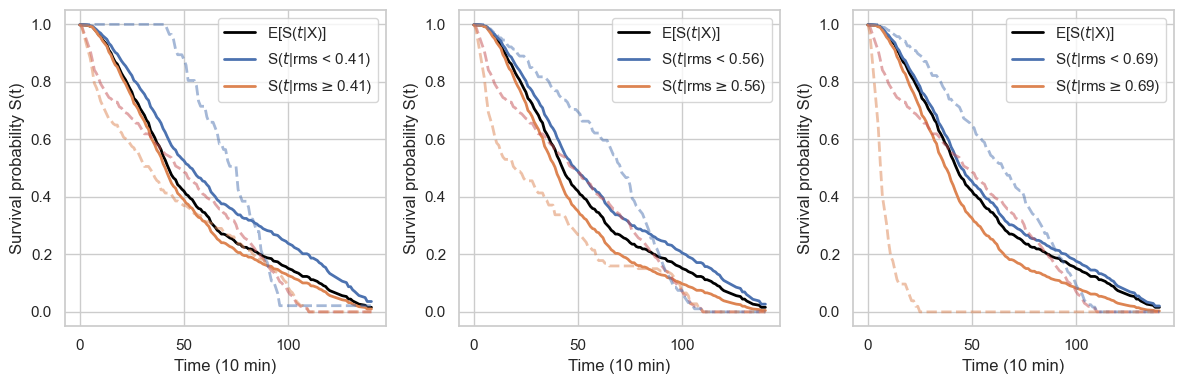

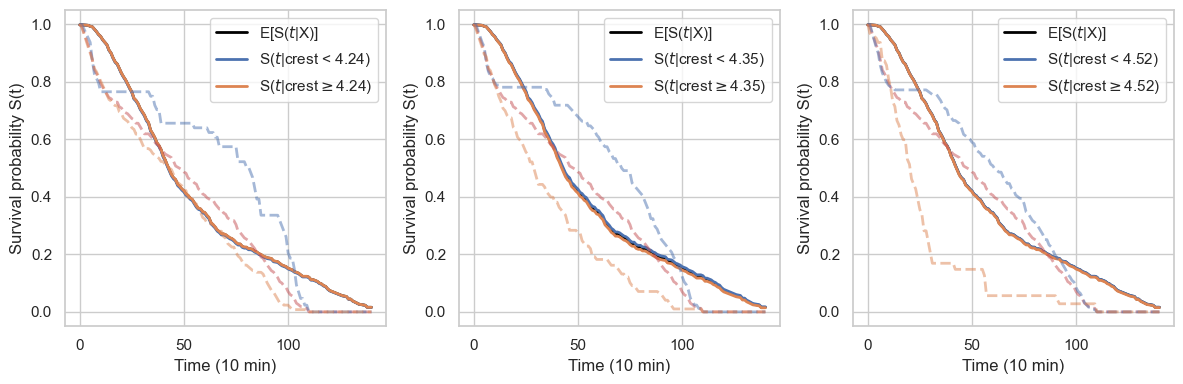

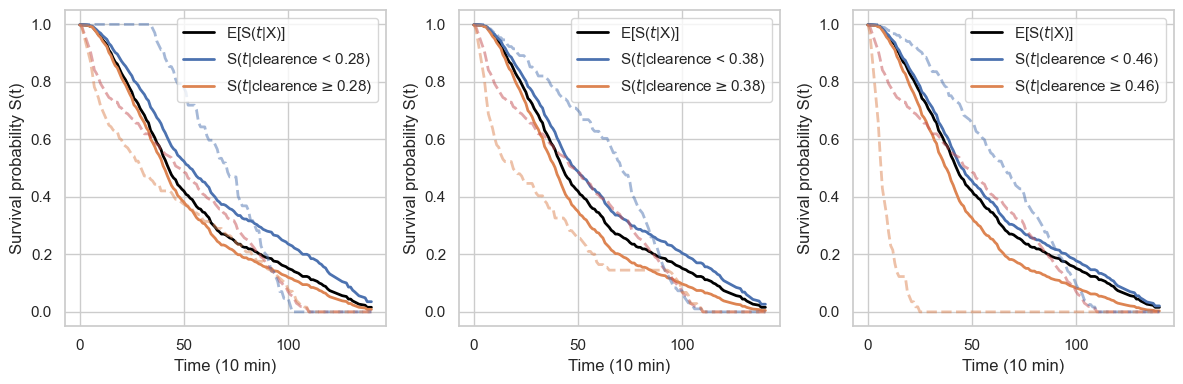

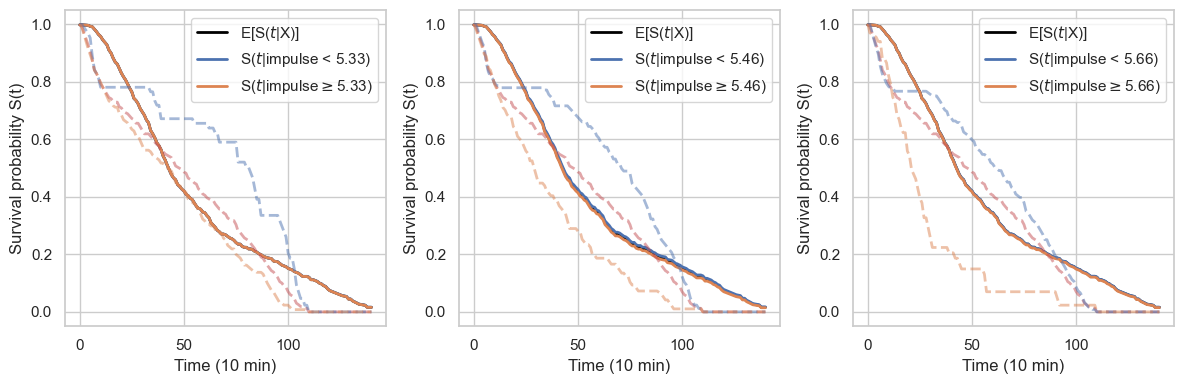

In [16]:
#Set up the models on test
params = regressors.DeepSurv().get_best_hyperparams()
model = regressors.DeepSurv().make_model(params)

#Format the data for NNs models
x = X_train_scaled.to_numpy()
t = y_train['Survival_time']
e = y_train['Event']

# Train the models and get the calculation time for each
#model.fit(X_train, y_train)
model.fit(x, t, e)

# Split data
features_to_split = best_features
for feature in features_to_split:
    split_thresholds = []
    for qct in [0.25, 0.5, 0.75]:
        split_thresholds.append(round(X_test[feature].quantile(qct), 2))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, st in enumerate(split_thresholds):
        g1_idx = X_test.loc[X_test[feature] < st].index
        g2_idx = X_test.loc[X_test[feature] >= st].index
        X_test_g1 = X_test.loc[g1_idx]
        X_test_g2 = X_test.loc[g2_idx]
        y_test_g1 = y_test[g1_idx]
        y_test_g2 = y_test[g2_idx]

        # Scale splitted data
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=best_features)
        X_test_g1_scaled = pd.DataFrame(scaler.transform(X_test_g1), columns=best_features)
        X_test_g2_scaled = pd.DataFrame(scaler.transform(X_test_g2), columns=best_features)

        # Predict for mean and two groups
        surv_probs = survival.predict_survival_function(model, np.array(X_test_scaled), event_times)
        km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                               y_test['Event'].reshape(1,-1),
                                                               event_times)
        surv_probs_g1 = survival.predict_survival_function(model, np.array(X_test_g1_scaled), event_times)
        km_mean_g1, km_high_g1, km_low_g1 = calculate_kaplan_vectorized(y_test_g1['Survival_time'].reshape(1,-1),
                                                                        y_test_g1['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_g2 = survival.predict_survival_function(model, np.array(X_test_g2_scaled), event_times)
        km_mean_g2, km_high_g2, km_low_g2 = calculate_kaplan_vectorized(y_test_g2['Survival_time'].reshape(1,-1),
                                                                        y_test_g2['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_mean = np.mean(surv_probs, axis=0)
        surv_probs_g1_mean = np.mean(surv_probs_g1, axis=0)
        surv_probs_g2_mean = np.mean(surv_probs_g2, axis=0)
        
        # Plot
        axes[i].plot(surv_probs_mean, linewidth=2, label="E[S($t$|X)]", color="black")
        axes[i].plot(surv_probs_g1_mean, linewidth=2, label=f'S($t$|{feature} < {st})', color="C0")
        axes[i].plot(surv_probs_g2_mean, linewidth=2, label=f'S($t$|{feature}$\geq${st})', color="C1")
        axes[i].plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C3")
        axes[i].plot(km_mean_g1.columns, km_mean_g1.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C0")
        axes[i].plot(km_mean_g2.columns, km_mean_g2.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C1")
        axes[i].set_xlabel("Time (10 min)")
        axes[i].set_ylabel("Survival probability S(t)")
        axes[i].legend(loc='upper right')
        fig.tight_layout()
        fig.show()

For bearing #21, event considered at the end of the recording
For bearing #31, event considered at the end of the recording
For bearing #11, event considered at the end of the recording


100%|██████████| 1/1 [00:00<00:00, 133.30it/s]


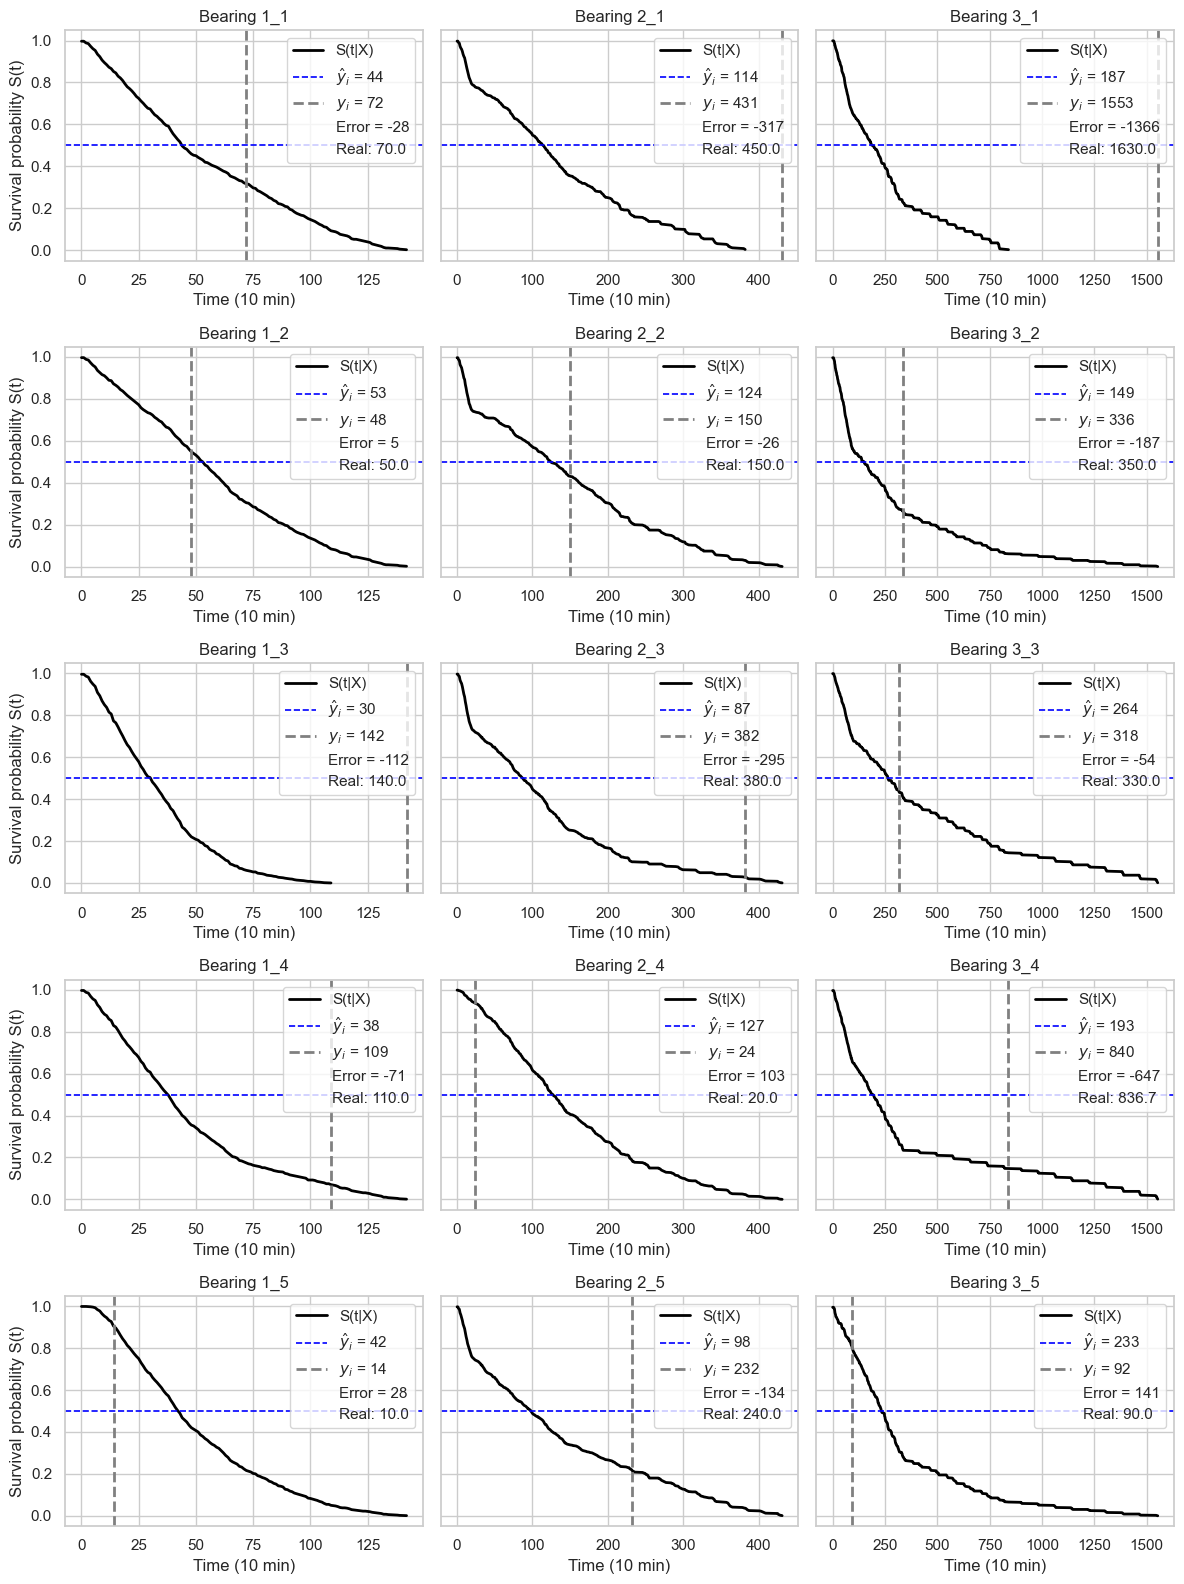

In [18]:
from matplotlib.patches import Rectangle

survival = Survival()
data_util = DataETL(DATASET, N_BOOT)

#Extract information from the dataset selected from the config file
cov_group = []
boot_group = []
info_group = []
for test_cond in range (0, N_CONDITION):
    cov, boot, info_pack = FileReader(DATASET).read_data(test_cond, N_BOOT)
    cov_group.append(cov)
    boot_group.append(boot)
    info_group.append(info_pack)

#Transform information from the dataset selected from the config file
data_container_X = []
data_container_y= []
for test_cond, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
    # Create different data for bootstrap and not bootstrap
    if TYPE == "bootstrap":
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_bootstrap(cov, boot, info_pack, N_BOOT)
    else:
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_upsampling(cov, boot, info_pack, N_BOOT, TYPE)
    data_container_X.append(data_temp_X)
    data_container_y.append(deltaref_temp_y)


fig, axes = plt.subplots(5, 3, figsize=(12,16), sharey=True)
for cond in [0, 1, 2]:
    # Load data
    X = data_container_X[cond]
    y = data_container_y[cond]

    data_X = []
    for data_group in X:   
        data_temp_X = Formatter.control_censored_data(data_group, percentage=PERCENTAGE)
        data_X.append(data_temp_X)
    X = data_X

    # Individual bearing prediction
    bearings = np.arange(0, N_BEARING)
    for idx in bearings:
        train_idx = bearings[np.arange(len(bearings))!=idx]
        test_idx = bearings[idx]
        
        X_train_merged = pd.DataFrame()
        for element in train_idx:
            X_train_merged = pd.concat([X_train_merged, X[element]], ignore_index=True)
        X_test_merged = X[test_idx]
        
        # Select first observation
        X_test_merged = X_test_merged[X_test_merged['Survival_time'] == X_test_merged['Survival_time'].max()] \
                        .drop_duplicates(subset="Survival_time")
        
        # Format data
        X_train = X_train_merged.drop(['Event', 'Survival_time'], axis=1)
        X_test = X_test_merged.drop(['Event', 'Survival_time'], axis=1)
        y_train = Surv.from_dataframe("Event", "Survival_time", X_train_merged)
        y_test = Surv.from_dataframe("Event", "Survival_time", X_test_merged)
        failure_time = int(y_test['Survival_time'])
        features = list(X_train.columns)
        
        #Set event times for general models and only NNs
        event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
        event_times = np.unique(event_times)

        #Set the feature selector and train/test split
        best_features = feature_selectors.PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
        X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

        # Scale train data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=best_features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=best_features)
        X_train_scaled.reset_index(inplace=True, drop=True)
        X_test_scaled.reset_index(inplace=True, drop=True)
        
        #Set up the models on test
        params = regressors.DeepSurv().get_best_hyperparams()
        model = regressors.DeepSurv().make_model(params)

        #Format the data for NNs models
        x = X_train_scaled.to_numpy()
        t_train = y_train['Survival_time']
        e_train = y_train['Event']
        t_test = y_test['Survival_time']
        e_test = y_test['Event']

        # Train the models and get the calculation time for each
        model.fit(x, t_train, e_train)
        
        # Predict
        surv_probs = survival.predict_survival_function(model, np.array(X_test_scaled), event_times)
        
        # Calculate TTE
        lifelines_eval = LifelinesEvaluator(surv_probs.T, t_test, e_test, t, e)
        median_survival_time = round(np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time)))
        mae = lifelines_eval.mae(method="Hinge")
        
        # Plot
        p1 = axes[idx, cond].plot(surv_probs.T, linewidth=2, label="S(t|X)", color="black")
        p2 = axes[idx, cond].axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1.2, label='$\hat{y}_{i}$ = ' + f'{median_survival_time}')        
        p3 = axes[idx, cond].axvline(x=failure_time, linestyle= "dashed", color='gray', linewidth=2.0, label=f'$y_i$ = {failure_time}')
        axes[idx, cond].set_title(f'Bearing {cond+1}_{idx+1}')
        axes[idx, cond].set_xlabel("Time (10 min)")
        text = f'Error = {median_survival_time-failure_time}'
        text2 = f'Real: {list(y.values())[idx]}'
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        axes[idx, cond].legend([p1[0], p2, p3, extra, extra], [p1[0].get_label(), p2.get_label(), p3.get_label(), text, text2], loc='upper right')
        if cond == 0:
            axes[idx, cond].set_ylabel("Survival probability S(t)")
plt.tight_layout()

In [ ]:
def plot_tte_median (km_sc, survival_probs, labels, data_time_te, data_event_te, data_time_tr, data_event_tr, time_bins):
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=80)

    colors= ["red", "green", "yellow", "orange"]

    lab_counter= 0

    for i, survival_prob in enumerate(survival_probs):
        #survival_prob = np.where(survival_prob[...][][...] > 0.5, survival_prob)

        probs_eval= np.mean(survival_prob, axis= 0)
        probs_eval= pd.DataFrame(probs_eval)
        probs_eval = probs_eval.fillna(0)
        #bad_idx = probs_eval[probs_eval.iloc[:,0] < 0.5].index # check we have a median
        #sanitized_surv_preds = probs_eval.drop(bad_idx).reset_index(drop=True)
        #sanitized_ytest = np.delete(y_test, bad_idx)
        lifelines_eval = LifelinesEvaluator(probs_eval.T, data_time_te, data_event_te, y_train['Survival_time'], y_train['Event'])

        median_survival_time = np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time))
        drop_num = math.floor(0.5 * 100 * (1 - 0.9))

        mean_outputs = pd.DataFrame(np.mean(probs_eval, axis=0), columns=[labels[lab_counter]])
        mean_outputs.plot(linewidth=1.5, color= colors[i], label= labels[lab_counter])

        lower_outputs = torch.kthvalue(torch.tensor(survival_prob), k= 1 + drop_num, dim=0)[0]
        upper_outputs = torch.kthvalue(torch.tensor(survival_prob), k= 100 - drop_num, dim=0)[0]

        #lower_outputs = np.mean(lower_outputs.numpy(), axis=0) #Take only the mean of all bearings
        #upper_outputs = np.mean(upper_outputs.numpy(), axis=0) #Take only the mean

        plt.fill_between(time_bins, upper_outputs[0,:], lower_outputs[0,:], linewidth=1, alpha=0.5)                
        plt.axvline(x=median_survival_time, color= colors[i], linestyle= "dashed", label='TtE estimation')
        lab_counter += 1
    
    km_sc.plot(linewidth=2, alpha=0.4, color='black', label= labels[lab_counter])
    probs= km_sc.survival_function_
    lifelines_eval = LifelinesEvaluator(probs, data_time_te, data_event_te,data_time_tr, data_event_tr)
    median_survival_time = np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time))        
    plt.axvline(x= median_survival_time, color='black', linestyle= "dashed", label='TtE estimation')

    plt.xlabel("Time (10 min)")
    plt.ylabel("Survival probability S(t)")
    plt.legend()
    plt.grid()

In [ ]:
# Format data
X_train = data_X_merge_tr.drop(['Event', 'Survival_time'], axis=1)
X_test = data_X_merge_te.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", data_X_merge_tr)
y_test = Surv.from_dataframe("Event", "Survival_time", data_X_merge_te)
features = list(X_train.columns)

#Set event times for general models and only NNs
lower, upper = np.percentile(y_train['Survival_time'], [0, 100])
event_times = np.arange(0, np.floor(upper))

#Set the feature selector and train/test split
best_features = feature_selectors.PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
X_train, X_test = X_train.loc[:,best_features], X_test.loc[:,best_features]

# Scale train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=best_features)
X_train_scaled.reset_index(inplace=True, drop=True) 

In [125]:
#Set up the models on test
cph_params = regressors.CoxPH().get_best_hyperparams()
cph_model = regressors.CoxPH().make_model(cph_params)

#Set the feature selector and train/test split
best_features = feature_selectors.NoneSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
X_train, X_test, X_train_NN, X_test_NN = X_train.loc[:, best_features], X_test.loc[:,best_features], \
                                         X_train_NN.loc[:, best_features], X_test_NN.loc[:, best_features]

#Format the data for NNs models
x = X_train_NN.to_numpy()
t = y_train_NN['time'].to_numpy()
e = y_train_NN['event'].to_numpy()
xte = X_test_NN.to_numpy()

#Format the data for parametric models
X_train_WB = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train['Survival_time'], columns=['Survival_time'])], axis=1)
X_train_WB = pd.concat([X_train_WB.reset_index(drop=True), pd.DataFrame(y_train['Event'], columns=['Event'])], axis=1)
X_test_WB = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test['Survival_time'], columns=['Survival_time'])], axis=1)
X_test_WB = pd.concat([X_test_WB.reset_index(drop=True), pd.DataFrame(y_test['Event'], columns=['Event'])], axis=1)

#Train the models and get the calculation time for each
cph_model.fit(X_train, y_train)

# Split data
X_test_g1 = X_test.loc[X_test[feature_to_split] < -0.5]
X_test_g2 = X_test.loc[X_test[feature_to_split] >= -0.5]

surv_probs_g1 = survival.predict_survival_function(cph_model, X_test_g1, event_times)
surv_probs_g2 = survival.predict_survival_function(cph_model, X_test_g2, event_times)
surv_probs_g1_mean = np.mean(surv_probs_g1, axis= 0)
surv_probs_g2_mean = np.mean(surv_probs_g2, axis= 0)

surv_probs_g1_ci = 1.96 * np.std(surv_probs_g1, axis=0) / np.sqrt(len(surv_probs_g1)) # 95% CI
surv_probs_g2_ci = 1.96 * np.std(surv_probs_g2, axis=0) / np.sqrt(len(surv_probs_g2))# 95% CI

surv_probs_g1_mean.T.plot(linewidth= 2, label= 'S (t|RMS>0)')
surv_probs_g2_mean.T.plot(linewidth= 2, label= 'S (t|RMS$\leq$0)')

plt.fill_between(event_times, surv_probs_g1_mean-surv_probs_g1_ci, surv_probs_g1_mean+surv_probs_g1_ci, linewidth=1, alpha=0.5)
plt.fill_between(event_times, surv_probs_g2_mean-surv_probs_g2_ci, surv_probs_g2_mean+surv_probs_g2_ci, linewidth=1, alpha=0.5)
    
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.legend()
plt.grid()

KeyError: 'p2p'

In [58]:
#Set up the models on test
cph_params = regressors.CoxPH().get_best_hyperparams()
cph_model = regressors.CoxPH().make_model(cph_params)

#Set the feature selector and train/test split
best_features = feature_selectors.PHSelector(X_train, y_train, estimator=[DATASET, TYPE]).get_features()
X_train, X_test, X_train_NN, X_test_NN = X_train.loc[:, best_features], X_test.loc[:,best_features], \
                                         X_train_NN.loc[:, best_features], X_test_NN.loc[:, best_features]

#Format the data for NNs models
x = X_train_NN.to_numpy()
t = y_train_NN['time'].to_numpy()
e = y_train_NN['event'].to_numpy()
xte = X_test_NN.to_numpy()

#Format the data for parametric models
X_train_WB = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train['Survival_time'], columns=['Survival_time'])], axis=1)
X_train_WB = pd.concat([X_train_WB.reset_index(drop=True), pd.DataFrame(y_train['Event'], columns=['Event'])], axis=1)
X_test_WB = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test['Survival_time'], columns=['Survival_time'])], axis=1)
X_test_WB = pd.concat([X_test_WB.reset_index(drop=True), pd.DataFrame(y_test['Event'], columns=['Event'])], axis=1)

#Train the models and get the calculation time for each
cph_model.fit(X_train, y_train)
#rsf_model.fit(X_train, y_train)
#NN_model.fit(x, t, e, vsize=0.3, **NN_params)
#DSM_model.fit(x, t, e, vsize=0.3, **DSM_params)
#BNN_model.fit(x, t, e)

# Survival functions for all test observations
cph_surv_func = survival.predict_survival_function(cph_model, X_test, event_times).reset_index(drop=True)
#rsf_surv_func = survival.predict_survival_function(rsf_model, X_test, event_times).reset_index(drop=True)
#NN_surv_func = survival.predict_survival_function(NN_model, xte, event_times).reset_index(drop=True)
#DSM_surv_func = survival.predict_survival_function(DSM_model, xte, event_times).reset_index(drop=True)
#BNN_surv_func = survival.predict_survival_function(BNN_model, xte, event_times).reset_index(drop=True)

The event detector establish an event for each bearing in:  {1: 84.8, 11: 126.3, 21: 73.4, 31: 66.2, 41: 17.5}


In [67]:
# Train the KM
plt.rcParams.update({'font.size': 12})
plt.figure(dpi=80)

surv_label= []
surv_label.append('S(t|RMS>0)')
surv_label.append('S(t|RMS$\leq$0)')

#Resumer.plot_aggregate_sl(BNN_model, FEATURE_TO_SPLIT, event_times, X_test, survival, val_ref, Km)

point = val_ref[0]
X_test_g1 = X_test.loc[X_test[FEATURE_TO_SPLIT] < point]
X_test_g2 = X_test.loc[X_test[FEATURE_TO_SPLIT] >= point]

surv_probs_g1 = survival.predict_survival_function(cph_model, X_test_g1, event_times)
surv_probs_g2 = survival.predict_survival_function(cph_model, X_test_g2, event_times)
surv_probs_g1_mean = np.mean(surv_probs_g1, axis= 0)
surv_probs_g2_mean = np.mean(surv_probs_g2, axis= 0)

surv_probs_g1_ci = 1.96 * np.std(surv_probs_g1, axis=0) / np.sqrt(len(surv_probs_g1)) # 95% CI
surv_probs_g2_ci = 1.96 * np.std(surv_probs_g2, axis=0) / np.sqrt(len(surv_probs_g2))# 95% CI

surv_probs_g1_mean.T.plot(linewidth= 2, label= 'S (t|RMS>0)')
surv_probs_g2_mean.T.plot(linewidth= 2, label= 'S (t|RMS$\leq$0)')

plt.fill_between(event_times, surv_probs_g1_mean-surv_probs_g1_ci, surv_probs_g1_mean+surv_probs_g1_ci, linewidth=1, alpha=0.5)
plt.fill_between(event_times, surv_probs_g2_mean-surv_probs_g2_ci, surv_probs_g2_mean+surv_probs_g2_ci, linewidth=1, alpha=0.5)
    
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.legend()
plt.grid()

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by CoxPHSurvivalAnalysis.

<Figure size 512x384 with 0 Axes>

# Second database for comparing PRONOSTIA

In [ ]:
N_REPEATS = 1
NEW_DATASET = False
DATASET = "xjtu"
TYPE = "not_correlated"  # not_correlated
CONDITION_SELECTOR = 0 #0 or 1 or 2
MERGE= False
LINE_PLOT = 3
TEST_SIZE= 0.3
FEATURE_TO_SPLIT = "rms"
SPLIT_THRESHOLD = [1.8] # [2] Only for xjtu
N_CONDITION = len (cfg.RAW_DATA_PATH_PRONOSTIA)
UNSUPERVISED_TEST = False

In [ ]:
if TYPE == "bootstrap":
    N_BOOT = 8
    cfg.DATA_TYPE = "bootstrap"
else:
    N_BOOT = 3
    cfg.DATA_TYPE = "not_bootstrap"        

if DATASET == "xjtu":
    data_path = cfg.RAW_DATA_PATH_XJTU
    N_CONDITION = len (data_path)
    N_BEARING = cfg.N_REAL_BEARING_XJTU
    N_SPLITS = 5
    TRAIN_SIZE = 1
    CENSORING = cfg.CENSORING_LEVEL  
elif DATASET == "pronostia":
    data_path = cfg.RAW_DATA_PATH_PRONOSTIA
    N_CONDITION = len (data_path)
    N_BEARING = cfg.N_REAL_BEARING_PRONOSTIA
    N_SPLITS = 2
    TRAIN_SIZE = 1
    CENSORING = cfg.CENSORING_LEVEL   

#For the first time running, a NEW_DATASET is needed
if NEW_DATASET== True:
    Builder(DATASET, N_BOOT).build_new_dataset(bootstrap=N_BOOT)   

survival = Survival()
data_util = DataETL(DATASET, N_BOOT)

#Extract information from the dataset selected from the config file
cov_group = []
boot_group = []
info_group = []
for i in range (0, N_CONDITION):
    cov, boot, info_pack = FileReader(DATASET).read_data(i, UNSUPERVISED_TEST, N_BOOT)
    cov_group.append(cov)
    boot_group.append(boot)
    info_group.append(info_pack)

#Transform information from the dataset selected from the config file
data_container_X = []
data_container_y= []

if MERGE == True:
    data_X_merge = pd.DataFrame()
    for i, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT, TYPE)
        if i== 0:
            deltaref_y_merge =  deltaref_temp_y
        else:
            deltaref_y_merge =  deltaref_y_merge.update(deltaref_temp_y)
        data_X_merge = pd.concat([data_X_merge, data_temp_X], ignore_index=True)
    data_container_X.append(data_X_merge)
    data_container_y.append(deltaref_y_merge)
else:
    for i, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
        data_temp_X, deltaref_y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT, TYPE)
        data_container_X.append(data_temp_X)
        data_container_y.append(deltaref_y)

#Load information from the dataset selected in the config file      
for cond, (X, y) in enumerate(zip(data_container_X, data_container_y)):

    if cond != CONDITION_SELECTOR:
        continue

    #Information about the event estimation in event detector
    y_delta = y
    print ("The event detector establish an event for each bearing in: ", y_delta)

    data_X= []
    for data_group in X:   
        data_temp_X  = data_util.control_censored_data(data_group, percentage= 0.1)
        data_X.append(data_temp_X)

    X = data_X

    for n_repeat in range(N_REPEATS):
        
        #Indexing the dataset to avoid train/test leaking
        bearing_idx'= list(range(0, N_BEARING))
        dummy_y= list(range(0, N_BEARING))

        #Test/train split
        X_train, X_test, y_train, y_test = train_test_split(bearing_idx', dummy_y, shuffle= False, test_size=TEST_SIZE, random_state=None)
        train_index = X_train
        test_index = X_test           
        
        #Load the indexed data  
        data_X_merge_tr = pd.DataFrame()
        data_X_merge_te = pd.DataFrame()
        for element in train_index:
            data_X_merge_tr = pd.concat([data_X_merge_tr, X[element]], ignore_index=True)
        for element in test_index:
            data_X_merge_te = pd.concat([data_X_merge_te, X[element]], ignore_index=True)

        data_X_train = data_X_merge_tr
        data_X_test = data_X_merge_te
        data_X = pd.concat([data_X_train, data_X_test], ignore_index=True) 
        data_y = data_X [["Survival_time", "Event"]]

        data_y_train = Surv.from_dataframe("Event", "Survival_time", data_X_train)
        data_y_test = Surv.from_dataframe("Event", "Survival_time", data_X_test)

        S1, S2 = (data_X_train, data_y_train), (data_X_test, data_y_test)

        #Format and centering the data
        set_tr_pure, set_te_pure, set_tr_NN_pure, set_te_NN_pure = data_util.format_main_data(S1, S2)
        percent_ref = data_util.calculate_positions_percentages(data_X, FEATURE_TO_SPLIT, SPLIT_THRESHOLD)
        set_tr, set_te, set_tr_NN, set_te_NN = data_util.centering_main_data(set_tr_pure, set_te_pure, set_tr_NN_pure, set_te_NN_pure)
        val_ref = data_util.find_values_by_percentages(data_X, FEATURE_TO_SPLIT, percent_ref)

        #Set up a general format for general models and NNs
        X_train2 = set_tr[0]
        y_train2 = set_tr[1]
        X_test2 = set_te[0]
        y_test2 = set_te[1]
        X_train_NN2 = set_tr_NN[0]
        y_train_NN2 = set_tr_NN[1]
        X_test_NN2 = set_te_NN[0]
        y_test_NN2 = set_te_NN[1]

        # #Eventually control the censored data
        # X_test_NN, y_test_NN = data_util.control_censored_data(X_test_NN, y_test_NN, percentage= 10)

        #Set event times for general models and only NNs
        lower, upper = np.percentile(data_X_train['Survival_time'], [0, 100])
        time_bins2 = np.arange(np.ceil(lower), np.floor(upper))
        lower_NN, upper_NN = np.percentile(y_test2[y_test.dtype.names[1]], [0, 100])
        times2 = np.arange(np.ceil(lower_NN), np.floor(upper_NN))

        #Set up the models on test
#        weibull_model = WeibullAFTFitter(alpha=0.4, penalizer=0.06)
#        boost_model = regressors.CoxBoost().make_model()
        cph_params = regressors.CoxPH().get_best_hyperparams()
        cph_model = regressors.CoxPH().make_model(cph_params)
        rsf_params = regressors.RSF().get_best_hyperparams()
        rsf_model = regressors.RSF().make_model(rsf_params)
        NN_model = regressors.DeepSurv().make_model()
        NN_params = regressors.DeepSurv().get_best_hyperparams()
        DSM_params = regressors.DSM().get_best_hyperparams()
        DSM_model = regressors.DSM().make_model(DSM_params)
        BNN_params = regressors.BNNmcd().get_best_hyperparams()
        BNN_model = regressors.BNNmcd().make_model(BNN_params)

        #Set the feature selector and train/test split
        best_features = feature_selectors.SelectPHFeatures(X_train2, y_train2, cph_model).get_features()
        X_train2, X_test2, X_train_NN2, X_test_NN2 = X_train.loc[:, best_features], X_test.loc[:,best_features], X_train_NN.loc[:, best_features], X_test_NN.loc[:, best_features]

        #Format the data for NNs models
        x2 = X_train_NN2.to_numpy()
        t2 = y_train_NN2['time'].to_numpy()
        e2 = y_train_NN2['event'].to_numpy()
        xte2 = X_test_NN2.to_numpy()

        #Format the data for parametric models
        X_train_WB2 = pd.concat([X_train2.reset_index(drop=True), pd.DataFrame(y_train['Survival_time'], columns=['Survival_time'])], axis=1)
        X_train_WB2 = pd.concat([X_train_WB2.reset_index(drop=True), pd.DataFrame(y_train['Event'], columns=['Event'])], axis=1)
        X_test_WB2 = pd.concat([X_test2.reset_index(drop=True), pd.DataFrame(y_test['Survival_time'], columns=['Survival_time'])], axis=1)
        X_test_WB2 = pd.concat([X_test_WB2.reset_index(drop=True), pd.DataFrame(y_test['Event'], columns=['Event'])], axis=1)

        #Train the models and get the calculation time for each
        #weibull_model.fit(X_train_WB, duration_col='Survival_time', event_col='Event')
        cph_model2.fit(X_train2, y_train2)
        rsf_model2.fit(X_train2, y_train2)
        #boost_model.fit(X_train, y_train)
        NN_model2.fit(x2, t2, e2, vsize=0.3, **NN_params)
        DSM_model2.fit(x2, t2, e2, vsize=0.3, **DSM_params)
        BNN_model2.fit(x2, t2, e2)

        #weibull_surv_func = survival.predict_survival_function(weibull_model, X_test_WB, times)
        cph_surv_func2 = survival.predict_survival_function(cph_model, X_test2, times2).reset_index(drop=True)
        #boost_surv_func = survival.predict_survival_function(boost_model, X_test, times2).reset_index(drop=True)
        rsf_surv_func2 = survival.predict_survival_function(rsf_model, X_test2, times2).reset_index(drop=True)
        NN_surv_func2 = survival.predict_survival_function(NN_model, xte2, times2).reset_index(drop=True)
        DSM_surv_func2 = survival.predict_survival_function(DSM_model, xte2, times2).reset_index(drop=True)
        BNN_surv_func2 = survival.predict_survival_function(BNN_model, xte2, times2).reset_index(drop=True)

# Survival lines

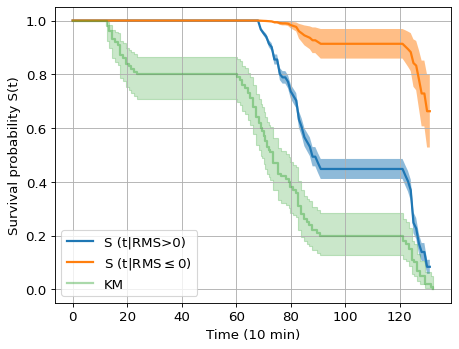

In [ ]:
# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

Resumer = Resume(data_X_test, data_y_test, DATASET)

Km= KaplanMeierFitter()
Km.fit(durations= data_X["Survival_time"], event_observed= data_X["Survival_time"])
Km.predict(event_times)

Resumer.plot_aggregate_sl(BNN_model, FEATURE_TO_SPLIT, event_times, X_test, survival, val_ref, Km)

In [ ]:
print (cph_model.coef_)

[ 3.34596186 -3.5270143  -0.1139902   1.13458019  0.17130277  2.41637782
  1.38678729  0.12499405 -3.77610918 -2.85088542 -0.84298826  3.37149141]


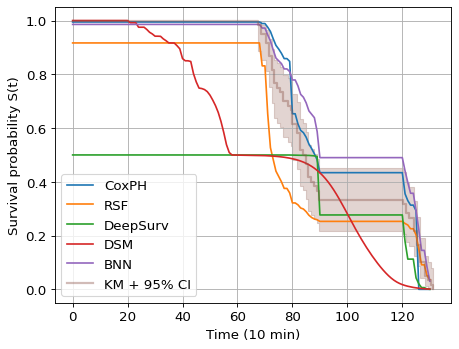

In [ ]:
# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

Resumer = Resume(data_X_test, data_y_test, DATASET)

Km= KaplanMeierFitter()
Km.fit(durations= data_X_train["Survival_time"], event_observed= data_X_train["Survival_time"])
Km.predict(event_times)

# cph_surv_func = survival.predict_survival_function(cph_model, X_test, time_bins).reset_index(drop=True)
# rsf_surv_func = survival.predict_survival_function(rsf_model, X_test, time_bins).reset_index(drop=True)
# NN_surv_func = survival.predict_survival_function(NN_model, xte, time_bins).reset_index(drop=True)  
# DSM_surv_func = survival.predict_survival_function(DSM_model, xte, time_bins).reset_index(drop=True)    
# BNN_surv_func = survival.predict_survival_function(BNN_model, xte, time_bins).reset_index(drop=True)    

surv_label= []
surv_label.append(cph_surv_func)
surv_label.append(rsf_surv_func)
surv_label.append(NN_surv_func)
surv_label.append(DSM_surv_func)
surv_label.append(BNN_surv_func)
   
Resumer.plot_aggregate_sl_mean (Km, surv_label)

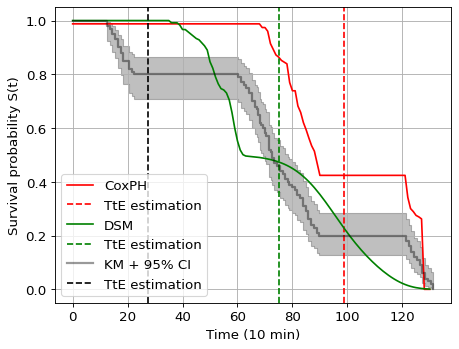

In [ ]:
# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

Resumer = Resume(data_X_test, data_y_test, DATASET)

Km= KaplanMeierFitter()
Km.fit(durations= data_X["Survival_time"], event_observed= data_X["Survival_time"])
Km.predict(event_times)

cph_surv_func = survival.predict_survival_function(cph_model, X_test, event_times)
#rsf_surv_func = survival.predict_survival_function(rsf_model, X_test, time_bins)
# NN_surv_func = survival.predict_survival_function(NN_model, xte, time_bins)
DSM_surv_func = survival.predict_survival_function(DSM_model, xte, event_times)
# BNN_surv_func = survival.predict_survival_function(BNN_model, xte, time_bins)

surv_label= []
surv_label.append('CoxPH')
# surv_label.append('RSF')
# surv_label.append('DeepSurv')
surv_label.append('DSM')
# surv_label.append('BNN')
surv_label.append('KM + 95% CI')

surv_probs= []
surv_probs.append(cph_surv_func)
# surv_probs.append(rsf_surv_func)
# surv_probs.append(NN_surv_func)
surv_probs.append(DSM_surv_func)
# surv_probs.append(BNN_surv_func)

Resumer.plot_tte_mean (Km, surv_probs, surv_label)         



<Figure size 512x384 with 0 Axes>

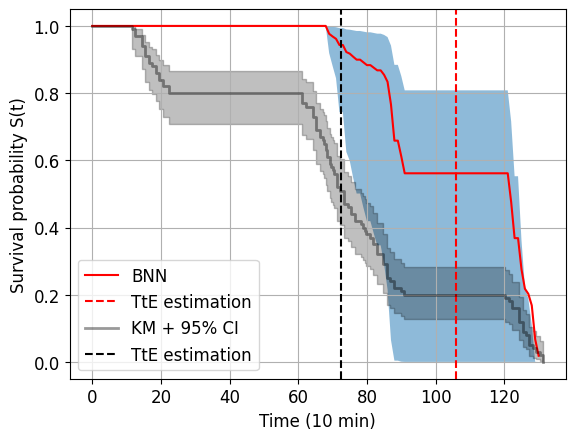

In [ ]:
# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

Resumer = Resume(data_X_test, data_y_test, DATASET)

Km= KaplanMeierFitter()
Km.fit(durations= data_X["Survival_time"], event_observed= data_X["Survival_time"])
Km.predict(event_times)

#cph_surv_func = survival.predict_survival_function(cph_model, X_test, time_bins)
#rsf_surv_func = survival.predict_survival_function(rsf_model, X_test, time_bins)
# NN_surv_func = survival.predict_survival_function(NN_model, xte, time_bins)
#DSM_surv_func = survival.predict_survival_function(DSM_model, xte, time_bins)
BNN_surv_func, y_test_sanitized = survival.pred_sanitize_surv_function(BNN_model, xte, event_times, y_test)

surv_label= []
#surv_label.append('CoxPH')
# surv_label.append('RSF')
# surv_label.append('DeepSurv')
# surv_label.append('DSM')
surv_label.append('BNN')
surv_label.append('KM + 95% CI')

surv_probs= []
#surv_probs.append(cph_surv_func)
# surv_probs.append(rsf_surv_func)
# surv_probs.append(NN_surv_func)
# surv_probs.append(DSM_surv_func)
surv_probs.append(BNN_surv_func)

plot_tte_median (Km, surv_probs, surv_label, y_test_sanitized['Survival_time'], y_test_sanitized['Event'], y_train['Survival_time'], y_train['Event'], event_times) 

In [ ]:
def plot_tte_median (km_sc, survival_probs, labels, data_time_te, data_event_te, data_time_tr, data_event_tr, time_bins):
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=80)

    colors= ["red", "green", "yellow", "orange"]

    lab_counter= 0

    for i, survival_prob in enumerate(survival_probs):
        #survival_prob = np.where(survival_prob[...][][...] > 0.5, survival_prob)

        probs_eval= np.mean(survival_prob, axis= 0)
        probs_eval= pd.DataFrame(probs_eval)
        probs_eval = probs_eval.fillna(0)
        #bad_idx = probs_eval[probs_eval.iloc[:,0] < 0.5].index # check we have a median
        #sanitized_surv_preds = probs_eval.drop(bad_idx).reset_index(drop=True)
        #sanitized_ytest = np.delete(y_test, bad_idx)
        lifelines_eval = LifelinesEvaluator(probs_eval.T, data_time_te, data_event_te, y_train['Survival_time'], y_train['Event'])

        median_survival_time = np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time))
        drop_num = math.floor(0.5 * 100 * (1 - 0.9))

        mean_outputs = pd.DataFrame(np.mean(probs_eval, axis=0), columns=[labels[lab_counter]])
        mean_outputs.plot(linewidth=1.5, color= colors[i], label= labels[lab_counter])

        lower_outputs = torch.kthvalue(torch.tensor(survival_prob), k= 1 + drop_num, dim=0)[0]
        upper_outputs = torch.kthvalue(torch.tensor(survival_prob), k= 100 - drop_num, dim=0)[0]

        #lower_outputs = np.mean(lower_outputs.numpy(), axis=0) #Take only the mean of all bearings
        #upper_outputs = np.mean(upper_outputs.numpy(), axis=0) #Take only the mean

        plt.fill_between(time_bins, upper_outputs[0,:], lower_outputs[0,:], linewidth=1, alpha=0.5)                
        plt.axvline(x=median_survival_time, color= colors[i], linestyle= "dashed", label='TtE estimation')
        lab_counter += 1
    
    km_sc.plot(linewidth=2, alpha=0.4, color='black', label= labels[lab_counter])
    probs= km_sc.survival_function_
    lifelines_eval = LifelinesEvaluator(probs, data_time_te, data_event_te,data_time_tr, data_event_tr)
    median_survival_time = np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time))        
    plt.axvline(x= median_survival_time, color='black', linestyle= "dashed", label='TtE estimation')

    plt.xlabel("Time (10 min)")
    plt.ylabel("Survival probability S(t)")
    plt.legend()
    plt.grid()

## Supervised phenotiping

LogRankResult(statistic=nan, pvalue=nan)


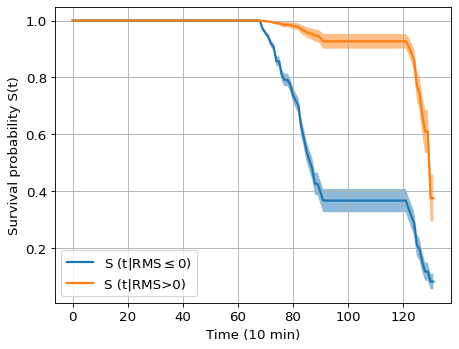

In [ ]:
# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

model = BNN_model
split_column = FEATURE_TO_SPLIT
survival_inst = survival
points = val_ref

surv_label= []
surv_label.append('S (t|RMS$\leq$0)')
surv_label.append('S (t|RMS>0)')

plt.style.use('default')
plt.rcParams.update({'font.size': 12})
plt.figure(dpi=80)

for point in points:

    X_test_g1 = X_test.loc[X_test[split_column] < point]
    X_test_g2 = X_test.loc[X_test[split_column] >= point]

    g1_index = X_test.loc[X_test['rms'] < 2].index
    g2_index = X_test.loc[X_test['rms'] >= 2].index

    y_test_g1 = y_test[g1_index]
    y_test_g2 = y_test[g2_index]

    y_test_event_time_g1U = y_test_g1[y_test_g1["Event"] == True] ["Survival_time"] 
    y_test_event_time_g2U = y_test_g2[y_test_g2["Event"] == True] ["Survival_time"]

    y_test_event_time_g1C = y_test_g1[y_test_g1["Event"] == False] ["Survival_time"] 
    y_test_event_time_g2C = y_test_g2[y_test_g2["Event"] == False] ["Survival_time"]

    y_1 = stats.CensoredData(
    uncensored=y_test_event_time_g1U,
    right=y_test_event_time_g1C
    )
    y_2 = stats.CensoredData(
    uncensored=y_test_event_time_g2U,
    right=y_test_event_time_g2C
    )  

    lr_test = stats.logrank(x=y_1, y=y_2)
    print (lr_test)

    surv_probs_g1 = survival_inst.predict_survival_function(model, X_test_g1, event_times)
    surv_probs_g2 = survival_inst.predict_survival_function(model, X_test_g2, event_times)
    surv_probs_g1_mean = np.mean(surv_probs_g1, axis= 0)
    surv_probs_g2_mean = np.mean(surv_probs_g2, axis= 0)

    time_ref = surv_probs_g1.columns

    surv_probs_g1_ci = 1.96 * np.std(surv_probs_g1, axis=0) / np.sqrt(len(surv_probs_g1)) # 95% CI
    surv_probs_g2_ci = 1.96 * np.std(surv_probs_g2, axis=0) / np.sqrt(len(surv_probs_g2))# 95% CI

    surv_probs_g1_mean.T.plot(linewidth= 2)
    surv_probs_g2_mean.T.plot(linewidth= 2)

    plt.fill_between(time_ref, surv_probs_g1_mean-surv_probs_g1_ci, surv_probs_g1_mean+surv_probs_g1_ci, linewidth=1, alpha=0.5)
    plt.fill_between(time_ref, surv_probs_g2_mean-surv_probs_g2_ci, surv_probs_g2_mean+surv_probs_g2_ci, linewidth=1, alpha=0.5)
    
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.legend(surv_label)
plt.grid()

In [ ]:
g1_index = X_train.loc[X_train['rms'] <= 2].index
g2_index = X_train.loc[X_train['rms'] > 2].index
y_train_g1 = y_train[g1_index]
y_train_g2 = y_train[g2_index]

risk_score_mean_g1 = cph_model.predict(X_test_g1)
risk_score_mean_g2 = cph_model.predict(X_test_g2)

def compute_survival_times(risk_scores, t_train, e_train, seed):
    # https://pubmed.ncbi.nlm.nih.gov/15724232/
    rnd = np.random.RandomState(seed)

    # generate survival time
    mean_survival_time = t_train[e_train].mean()
    baseline_hazard = 1. / mean_survival_time
    scale = baseline_hazard * np.exp(risk_scores)
    u = rnd.uniform(low=0, high=1, size=risk_scores.shape[0])
    t = -np.log(u) / scale

    return t, scale

surv_times1, scales1, surv_times2, scales2 = list(), list(), list(), list()
for i in range(0, 500):
    surv_time1, scale1 = compute_survival_times(risk_score_mean_g1, y_train_g1['Survival_time'], y_train_g1['Event'], i)
    surv_time2, scale2 = compute_survival_times(risk_score_mean_g2, y_train_g2['Survival_time'], y_train_g2['Event'], i)
    surv_times1.append(surv_time1[0])
    scales1.append(scale1[0])
    surv_times2.append(surv_time2[0])
    scales2.append(scale2[0])

Text(0.5, 0, 'Time (10 min)')

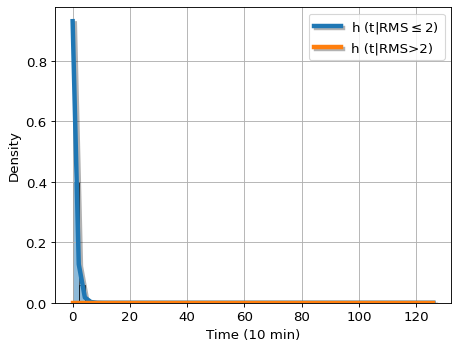

In [ ]:
surv_label= []
surv_label.append('h (t|RMS$\leq$2)')
surv_label.append('h (t|RMS>2)')


plt.rcParams.update({'font.size': 12})

plt.figure(dpi=80)
hist_bins = np.linspace(0, 126, 60)
sns.histplot(surv_times1, bins=hist_bins, label="Surv times", alpha=0.5, stat="density")
sns.histplot(surv_times2, bins=hist_bins, label="Surv times", alpha=0.5, stat="density")
y1 = scale1[0] * np.exp(-scale1[0]*hist_bins)
y2 = scale2[0] * np.exp(-scale2[0]*hist_bins)
plt.plot(hist_bins, y1, linewidth=4, path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
plt.plot(hist_bins, y2, linewidth=4, path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
plt.legend(surv_label)
plt.grid()
plt.xlabel("Time (10 min)")

# Log-Rank in time

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

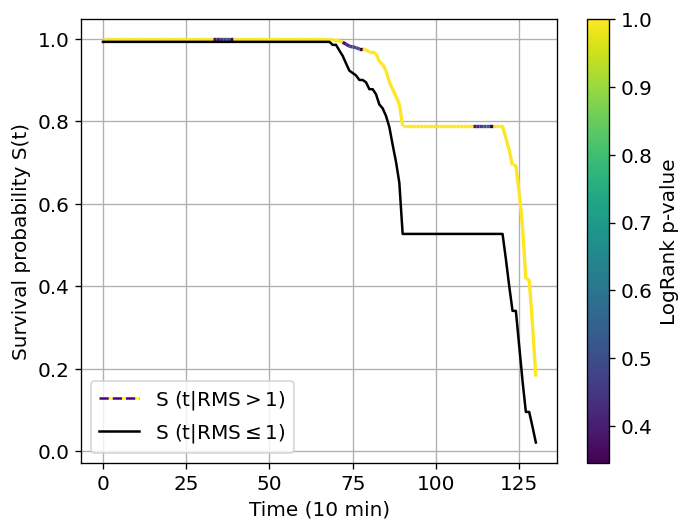

In [ ]:
# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

model = BNN_model
split_column = FEATURE_TO_SPLIT
survival_inst = survival
points = val_ref

lr_test = []

plt.style.use('default')


for point in points:
    for index in range(1, len(X_test)):
        x_test = X_test[:index]

        X_test_g1 = x_test.loc[x_test[split_column] < point]
        X_test_g2 = x_test.loc[x_test[split_column] >= point]

        if len(X_test_g1) == 0 or len(X_test_g2) == 0:
            if index == 1:
                lr_test.append(1)
            else:
                lr_test.append(lr_test[index - 2])
            continue

        g1_index = x_test.loc[x_test['rms'] < point].index
        g2_index = x_test.loc[x_test['rms'] >= point].index

        y_test_g1 = y_test[g1_index]
        y_test_g2 = y_test[g2_index]

        y_test_event_time_g1U = y_test_g1[y_test_g1["Event"] == True] ["Survival_time"] 
        y_test_event_time_g2U = y_test_g2[y_test_g2["Event"] == True] ["Survival_time"]

        y_test_event_time_g1C = y_test_g1[y_test_g1["Event"] == False] ["Survival_time"] 
        y_test_event_time_g2C = y_test_g2[y_test_g2["Event"] == False] ["Survival_time"]

        y_1 = stats.CensoredData(
        uncensored=y_test_event_time_g1U,
        right=y_test_event_time_g1C
        )
        y_2 = stats.CensoredData(
        uncensored=y_test_event_time_g2U,
        right=y_test_event_time_g2C
        )  

        lr_test.append(stats.logrank(x=y_1, y=y_2).pvalue)

        #wilcoxon_test = stats.wilcoxon(x=X_train, y=X_test)
        #print (wilcoxon_test)

    X_test_g1 = X_test.loc[X_test[split_column] < point]
    X_test_g2 = X_test.loc[X_test[split_column] >= point]

    if len(X_test_g1) == 0 or len(X_test_g2) == 0:
        if index == 1:
            lr_test.append(1)
        else:
            lr_test.append(lr_test[index - 2])
        continue

    g1_index = X_test.loc[X_test['rms'] < point].index
    g2_index = X_test.loc[X_test['rms'] >= point].index

    y_test_g1 = y_test[g1_index]
    y_test_g2 = y_test[g2_index]

    y_test_event_time_g1U = y_test_g1[y_test_g1["Event"] == True] ["Survival_time"] 
    y_test_event_time_g2U = y_test_g2[y_test_g2["Event"] == True] ["Survival_time"]

    y_test_event_time_g1C = y_test_g1[y_test_g1["Event"] == False] ["Survival_time"] 
    y_test_event_time_g2C = y_test_g2[y_test_g2["Event"] == False] ["Survival_time"]

    surv_probs_g1 = survival_inst.predict_survival_function(model, X_test_g1, event_times)
    surv_probs_g2 = survival_inst.predict_survival_function(model, X_test_g2, event_times)
    surv_probs_g1_mean = np.mean(surv_probs_g1, axis= 0)
    surv_probs_g2_mean = np.mean(surv_probs_g2, axis= 0)

    event_times = surv_probs_g1.columns

    surv_probs_g1_ci = 1.96 * np.std(surv_probs_g1, axis=0) / np.sqrt(len(surv_probs_g1)) # 95% CI
    surv_probs_g2_ci = 1.96 * np.std(surv_probs_g2, axis=0) / np.sqrt(len(surv_probs_g2))# 95% CI

    # surv_probs1_mean.T.plot(linewidth= 2)
    # surv_probs2_mean.T.plot(linewidth= 2)

    # plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5)
    # plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5) 

hF= surv_probs_g2_mean.T
hF2= surv_probs_g1_mean.T
x = np.arange(len(hF))
y = hF
dydx = lr_test

# Create a set of line segments so that we can color them individually
# This creates the points as an N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

plt.rcParams.update({'font.size': 12})
fig = plt.figure(dpi=120) 

ax = plt.gca()

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(min(dydx), max(dydx))
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = ax.add_collection(lc)
colorbar=plt.colorbar(line, ax=ax, label='LogRank p-value')
ref_line = plt.plot(hF2, color='black')
ax.set_xlabel("Time (10 min)")
ax.set_ylabel("Survival probability S(t)")
plt.grid()

legend_elements = [
    Line2D([0], [0], color='indigo', linestyle= "--" , gapcolor= "yellow", label='S (t|RMS$ > $1)'),
    Line2D([0], [0], color='black', label='S (t|RMS$\leq$1)')
]

plt.legend(handles=legend_elements)
plt.show()


## Cutpoints with features (Stratification)

In [ ]:
def transform_column_with_cutpoints(dataset, cut_points, column_name):
    new_df = dataset.copy()
    for cut_point in cut_points:
        new_column_name = f"{column_name}_<=_{cut_point}"
        new_df[new_column_name] = dataset[column_name] >= cut_point
    
    return new_df

# Example usage
data = {
    'age': [25, 30, 40, 22, 35, 42, 28, 50, 60],
    'income': [50000, 60000, 75000, 40000, 65000, 80000, 55000, 90000, 95000]
}

df = pd.DataFrame(data)

cut_points = [30, 40, 50]
column_to_transform = 'age'

transformed_df = transform_column_with_cutpoints(df, cut_points, column_to_transform)
print(transformed_df)

   age  income  age_<=_30  age_<=_40  age_<=_50
0   25   50000      False      False      False
1   30   60000       True      False      False
2   40   75000       True       True      False
3   22   40000      False      False      False
4   35   65000       True      False      False
5   42   80000       True       True      False
6   28   55000      False      False      False
7   50   90000       True       True       True
8   60   95000       True       True       True


## Unsupervised stratification

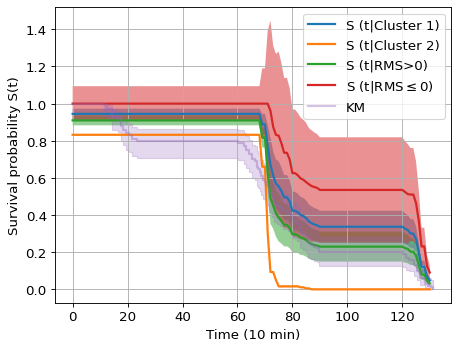

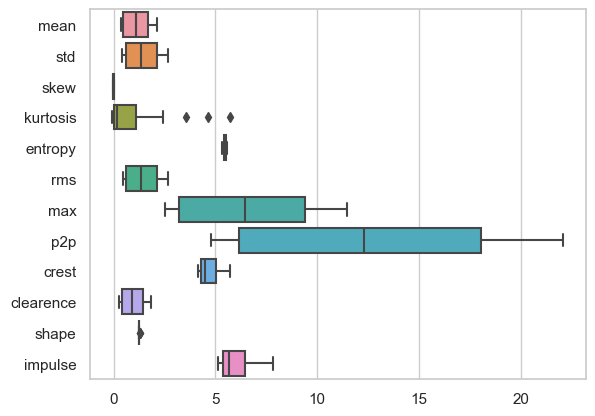

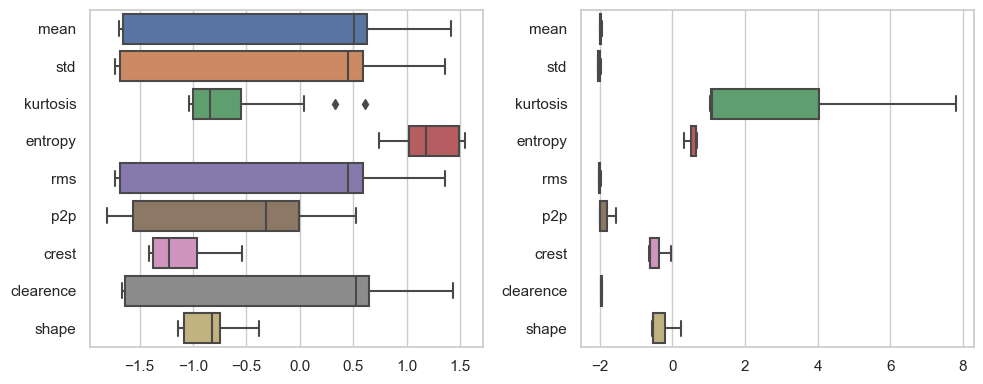

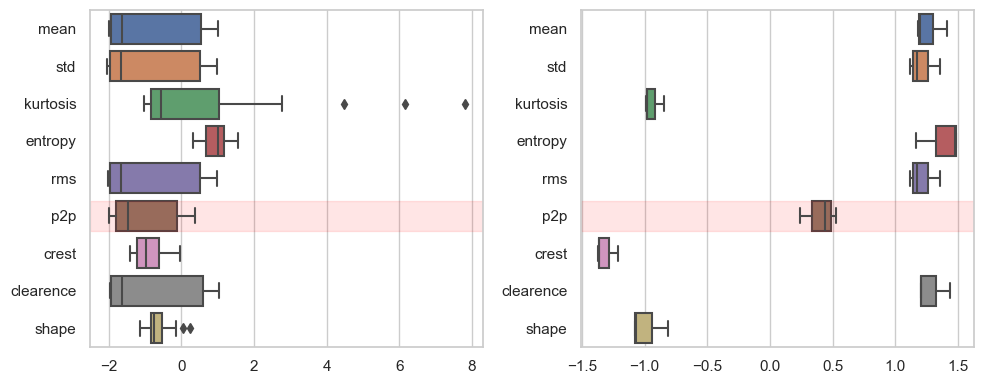

In [ ]:
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

model = rsf_model
split_column = FEATURE_TO_SPLIT
event_times = event_times
survival_inst = survival
points = val_ref

reducer = umap.UMAP(n_neighbors= 6,
                    min_dist= 0.8,
                    metric="manhattan")
embedding = reducer.fit_transform(X_test)

# pca = PCA(n_components=2)
# embedding = pca.fit_transform(X_test)

# Cluster the lower-dimensional representation using Agglomerative Clustering
num_clusters = 2
agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
labels = agglomerative.fit_predict(embedding)

# Add the cluster labels back to the DataFrame
X_test['cluster'] = labels

# # Visualize the clusters
# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis')
# plt.colorbar()
# plt.show()

# # Print the cluster assignments
# print(df)

surv_label= []
surv_label.append('S (t|Cluster 1)')
surv_label.append('S (t|Cluster 2)')
surv_label.append('S (t|RMS$\leq$0)')
surv_label.append('S (t|RMS>0)')
#surv_label.append('P(S(t)|CLUSTER 3)')


plt.style.use('default')
plt.rcParams.update({'font.size': 12})
plt.figure(dpi=80)


X_test_g1 = X_test.loc[X_test['cluster'] == 0]
X_test_g2 = X_test.loc[X_test['cluster'] == 1]
#    X_test_g3 = X_test.loc[X_test['cluster'] == 2]

X_test_g1 = X_test_g1.drop('cluster', axis=1)
X_test_g2 = X_test_g2.drop('cluster', axis=1)
#    X_test_g3 = X_test_g3.drop('cluster', axis=1)           

surv_probs_g1 = survival_inst.predict_survival_function(model, X_test_g1, event_times)
surv_probs_g2 = survival_inst.predict_survival_function(model, X_test_g2, event_times)
#    surv_probs3 = survival_inst.predict_survival_function(model, X_test_g3, time_bins)
surv_probs_g1_mean = np.mean(surv_probs_g1, axis= 0)
surv_probs_g2_mean = np.mean(surv_probs_g2, axis= 0)
#    surv_probs3_mean = np.mean(surv_probs3, axis= 0)

time_ref = surv_probs_g1.columns

surv_probs_g1_ci = 1.96 * np.std(surv_probs_g1, axis=0) / np.sqrt(len(surv_probs_g1)) # 95% CI
surv_probs_g2_ci = 1.96 * np.std(surv_probs_g2, axis=0) / np.sqrt(len(surv_probs_g2))# 95% CI
#    surv_probs3_ci = 1.96 * np.std(surv_probs3, axis=0) / np.sqrt(len(surv_probs3))# 95% CI

surv_probs_g1_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 1)')
surv_probs_g2_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 2)')
#    surv_probs3_mean.T.plot(linewidth= 2)

plt.fill_between(time_ref, surv_probs_g1_mean-surv_probs_g1_ci, surv_probs_g1_mean+surv_probs_g1_ci, linewidth=1, alpha=0.5,)
plt.fill_between(time_ref, surv_probs_g2_mean-surv_probs_g2_ci, surv_probs_g2_mean+surv_probs_g2_ci, linewidth=1, alpha=0.5)
#    plt.fill_between(time_bins, surv_probs3_mean-surv_probs3_ci, surv_probs3_mean+surv_probs3_ci, linewidth=1, alpha=0.5)

X_test = X_test.drop('cluster', axis=1)

for point in points:
    X_test_s3 = X_test.loc[X_test[split_column] < point]
    X_test_s4 = X_test.loc[X_test[split_column] >= point]

    surv_probs_s3 = survival_inst.predict_survival_function(model, X_test_s3, event_times)
    surv_probs_s4 = survival_inst.predict_survival_function(model, X_test_s4, event_times)
    surv_probs_s3_mean = np.mean(surv_probs_s3, axis= 0)
    surv_probs_s4_mean = np.mean(surv_probs_s4, axis= 0)

    time_ref = surv_probs_s3.columns

    surv_probs3_ci = 1.96 * np.std(surv_probs_s3, axis=0) / np.sqrt(len(surv_probs_s3)) # 95% CI
    surv_probs4_ci = 1.96 * np.std(surv_probs_s3, axis=0) / np.sqrt(len(surv_probs_s4))# 95% CI

    surv_probs_s3_mean.T.plot(linewidth= 2, label= 'S (t|RMS>0)')
    surv_probs_s4_mean.T.plot(linewidth= 2, label= 'S (t|RMS$\leq$0)')

    plt.fill_between(time_ref, surv_probs_s3_mean-surv_probs3_ci, surv_probs_s3_mean+surv_probs3_ci, linewidth=1, alpha=0.5)
    plt.fill_between(time_ref, surv_probs_s4_mean-surv_probs4_ci, surv_probs_s4_mean+surv_probs4_ci, linewidth=1, alpha=0.5)

Km.plot(linewidth=2, alpha=0.4, label= 'KM')
    
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.legend()
# plt.legend(surv_label)
plt.grid()
plt.show()

sns.set()
sns.set_style("whitegrid")
sns.boxplot(data=set_te_pure[0].iloc[:,:12], orient= "h") # notch=True
plt.show()

fig_cluster, axes_cluster = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=X_test_g1,ax=axes_cluster[0], orient= "h") # notch=True
sns.set_style("whitegrid")

sns.boxplot(data=X_test_g2,ax=axes_cluster[1], orient= "h")
sns.set_style("whitegrid")
fig_cluster.tight_layout()

fig_supervised, axes_supervised = plt.subplots(1, 2, figsize=(10, 4))

axes_supervised[0].axhspan(5-0.4,5+0.4, color='red', alpha=0.1)    
sns.boxplot(data=X_test_s3,ax=axes_supervised[0], orient= "h")
sns.set_style("whitegrid")

axes_supervised[1].axhspan(5-0.4,5+0.4, color='red', alpha=0.1) 
sns.boxplot(data=X_test_s4,ax=axes_supervised[1], orient= "h")
sns.set_style("whitegrid")
fig_supervised.tight_layout()

## -Ln (-Ln) plot

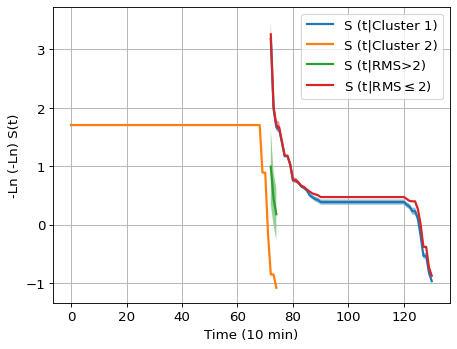

In [ ]:
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# cph_model
# rsf_model
# NN_model
# DSM_model
# BNN_model

model = rsf_model
split_column = FEATURE_TO_SPLIT
event_times = event_times
survival_inst = survival
points = val_ref

reducer = umap.UMAP(n_neighbors= 6,
                    min_dist= 0.8,
                    metric="manhattan")
embedding = reducer.fit_transform(X_test)

# pca = PCA(n_components=2)
# embedding = pca.fit_transform(X_test)

# Cluster the lower-dimensional representation using Agglomerative Clustering
num_clusters = 2
agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
labels = agglomerative.fit_predict(embedding)

# Add the cluster labels back to the DataFrame
X_test['cluster'] = labels

# # Visualize the clusters
# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis')
# plt.colorbar()
# plt.show()

# # Print the cluster assignments
# print(df)

surv_label= []
surv_label.append('S (t|Cluster 1)')
surv_label.append('S (t|Cluster 2)')
surv_label.append('S (t|RMS>2)')
surv_label.append('S (t|RMS$\leq$2)')
#surv_label.append('P(S(t)|CLUSTER 3)')

plt.style.use('default')
plt.rcParams.update({'font.size': 12})
plt.figure(dpi=80)

for point in points:
    X_test_g1 = X_test.loc[X_test['cluster'] == 0]
    X_test_g2 = X_test.loc[X_test['cluster'] == 1]
#    X_test_g3 = X_test.loc[X_test['cluster'] == 2]

    X_test_g1 = X_test_g1.drop('cluster', axis=1)
    X_test_g2 = X_test_g2.drop('cluster', axis=1)
#    X_test_g3 = X_test_g3.drop('cluster', axis=1)           

    surv_probs_g1 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g1, event_times)))
    surv_probs_g2 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g2, event_times)))
#    surv_probs3 = survival_inst.predict_survival_function(model, X_test_g3, time_bins)
    surv_probs_g1_mean = np.mean(surv_probs_g1, axis= 0)
    surv_probs_g2_mean = np.mean(surv_probs_g2, axis= 0)
#    surv_probs3_mean = np.mean(surv_probs3, axis= 0)

    time_ref = surv_probs_g1.columns

    surv_probs_g1_ci = 1.96 * np.std(surv_probs_g1, axis=0) / np.sqrt(len(surv_probs_g1)) # 95% CI
    surv_probs_g2_ci = 1.96 * np.std(surv_probs_g2, axis=0) / np.sqrt(len(surv_probs_g2))# 95% CI
#    surv_probs3_ci = 1.96 * np.std(surv_probs3, axis=0) / np.sqrt(len(surv_probs3))# 95% CI

    surv_probs_g1_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 1)')
    surv_probs_g2_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 2)')
#    surv_probs3_mean.T.plot(linewidth= 2)

    plt.fill_between(time_ref, surv_probs_g1_mean-surv_probs_g1_ci, surv_probs_g1_mean+surv_probs_g1_ci, linewidth=1, alpha=0.5,)
    plt.fill_between(time_ref, surv_probs_g2_mean-surv_probs_g2_ci, surv_probs_g2_mean+surv_probs_g2_ci, linewidth=1, alpha=0.5)
#    plt.fill_between(time_bins, surv_probs3_mean-surv_probs3_ci, surv_probs3_mean+surv_probs3_ci, linewidth=1, alpha=0.5)

X_test = X_test.drop('cluster', axis=1)

for point in points:
    X_test_g1 = X_test.loc[X_test[split_column] < point]
    X_test_g2 = X_test.loc[X_test[split_column] >= point]

    surv_probs_g1 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g1, event_times)))
    surv_probs_g2 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g2, event_times)))
    surv_probs_g1_mean = np.mean(surv_probs_g1, axis= 0)
    surv_probs_g2_mean = np.mean(surv_probs_g2, axis= 0)

    time_ref = surv_probs_g1.columns

    surv_probs_g1_ci = 1.96 * np.std(surv_probs_g1, axis=0) / np.sqrt(len(surv_probs_g1)) # 95% CI
    surv_probs_g2_ci = 1.96 * np.std(surv_probs_g2, axis=0) / np.sqrt(len(surv_probs_g2))# 95% CI

    surv_probs_g1_mean.T.plot(linewidth= 2, label= 'S (t|RMS>2)')
    surv_probs_g2_mean.T.plot(linewidth= 2, label= 'S (t|RMS$\leq$2)')

    plt.fill_between(time_ref, surv_probs_g1_mean-surv_probs_g1_ci, surv_probs_g1_mean+surv_probs_g1_ci, linewidth=1, alpha=0.5)
    plt.fill_between(time_ref, surv_probs_g2_mean-surv_probs_g2_ci, surv_probs_g2_mean+surv_probs_g2_ci, linewidth=1, alpha=0.5)

#Km_probs= - np.log(- np.log(Km.predict(time_bins)))
#Km_probs.plot(linewidth=2, alpha=0.4, label= 'KM')
    
plt.xlabel("Time (10 min)")
plt.ylabel("-Ln (-Ln) S(t)")
plt.legend()
# plt.legend(surv_label)
plt.grid()

## RMST (Restricted Mean Survival Time)

<Axes: xlabel='timeline'>

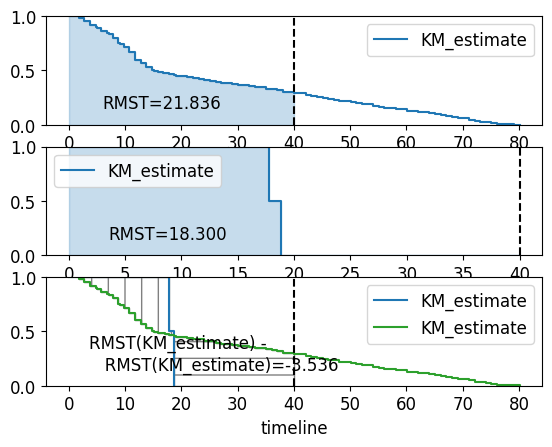

In [ ]:
from matplotlib import pyplot as plt
from lifelines.plotting import rmst_plot

time_limit= 40

Km1= KaplanMeierFitter()
X_test_WB1 = X_test_WB.loc[X_test_WB[split_column] < point]
Km1.fit(durations= X_test_WB1["Survival_time"], event_observed= X_test_WB1["Survival_time"])

ax = plt.subplot(311)
rmst_plot(Km1 , t= time_limit, ax=ax)

Km2= KaplanMeierFitter()
X_test_WB2 = X_test_WB.loc[X_test_WB[split_column] >= point]
Km2.fit(durations= X_test_WB2["Survival_time"], event_observed= X_test_WB2["Survival_time"])

ax2 = plt.subplot(312)
rmst_plot(Km2, t= time_limit, ax=ax2)


ax3 = plt.subplot(313)
rmst_plot(Km2, model2=Km1, t= time_limit, ax=ax3)

<Axes: xlabel='timeline'>

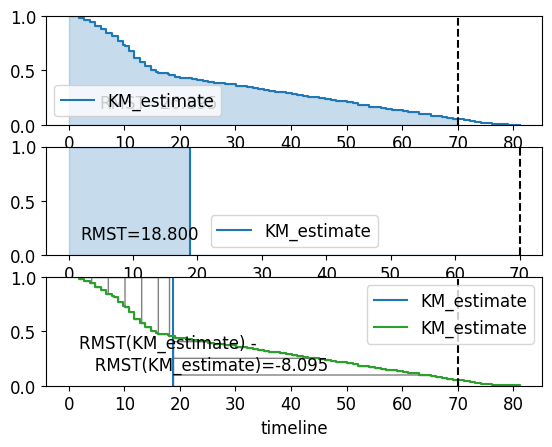

In [ ]:
time_limit= 70

Km1= KaplanMeierFitter()
Km1.fit(durations= X_test_WB["Survival_time"], event_observed= X_test_WB["Survival_time"])

ax = plt.subplot(311)
rmst_plot(Km1 , t= time_limit, ax=ax)

Km2= KaplanMeierFitter()
Km2.fit(durations= X_test_WB2["Survival_time"], event_observed= X_test_WB2["Survival_time"])

ax2 = plt.subplot(312)
rmst_plot(Km2, t= time_limit, ax=ax2)


ax3 = plt.subplot(313)
rmst_plot(Km2, model2=Km1, t= time_limit, ax=ax3)

## Test PH assumption

In [ ]:
N_BOOT = cfg.N_BOOT
N_REPEATS = 1
NEW_DATASET = False
DATASET = "xjtu"
TYPE = "correlated"  # not_correlated
MERGE= False
LINE_PLOT = 3
FEATURE_TO_SPLIT = "rms"
SPLIT_THRESHOLD = [] # [2] Only for xjtu
N_CONDITION = len (cfg.RAW_DATA_PATH_PRONOSTIA)


global BOOT_NO
global TEST_SIZE

if TYPE == "bootstrap":
    cfg.N_BOOT = 3
    cfg.DATA_TYPE = "bootstrap"
else:
    cfg.DATA_TYPE = "not_bootstrap"        

if DATASET == "xjtu":
    N_CONDITION = len (cfg.RAW_DATA_PATH_XJTU)
    N_BEARING = cfg.N_REAL_BEARING_XJTU
    N_SPLITS = 5
    TRAIN_SIZE = 1
    CENSORING = cfg.CENSORING_LEVEL  
elif DATASET == "pronostia":
    N_CONDITION = len (cfg.RAW_DATA_PATH_PRONOSTIA)
    N_BEARING = cfg.N_REAL_BEARING_PRONOSTIA
    N_SPLITS = 2
    TRAIN_SIZE = 1
    CENSORING = cfg.CENSORING_LEVEL  

#For the first time running, a NEW_DATASET is needed
if NEW_DATASET == True:
    Builder(DATASET).build_new_dataset(bootstrap=N_BOOT)

#Prepare the object needed
survival = Survival()
data_util = DataETL(DATASET) 

#Eventually plot and create a table for CV search 
#Resumer.table_result_hyper()
#Resumer.presentation(N_BEARING, BOOT_NO)

#Extract information from the dataset selected from the config file
cov_group = []
boot_group = []
info_group = []
for i in range (0, N_CONDITION):
    cov, boot, info_pack = FileReader(DATASET).read_data(i)
    cov_group.append(cov)
    boot_group.append(boot)
    info_group.append(info_pack)

#Transform information from the dataset selected from the config file
data_container_X = []
data_container_y= []
if MERGE == True:
    data_X_merge = pd.DataFrame()
    for i, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT, TYPE)
        if i== 0:
            deltaref_y_merge =  deltaref_temp_y
        else:
            deltaref_y_merge =  deltaref_y_merge.update(deltaref_temp_y)
        data_X_merge = pd.concat([data_X_merge, data_temp_X], ignore_index=True)
    data_container_X.append(data_X_merge)
    data_container_y.append(deltaref_y_merge)
else:
    for i, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
        data_temp_X, deltaref_y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT, TYPE)
        data_container_X.append(data_temp_X)
        data_container_y.append(deltaref_y)

In [ ]:
cph = CoxPHFitter()#penalizer= 0.0001
X = data_container_X[2][0].append(data_container_X[2][1], ignore_index= True)
X = X.append(data_container_X[2][2], ignore_index= True)
X = X.append(data_container_X[2][3], ignore_index= True)
X = X.append(data_container_X[2][4], ignore_index= True)
X_spec= X.loc[:, ~X.columns.isin(['Fca','Fi','Fo','Fr','Frp','FoH', 'FiH', 'FrH', 'FrpH', 'FcaH', 'noise', 'entropy', 'p2p', 'impulse','max', 'kurtosis', 'crest', 'shape', 'skew', 'mean'])] #'max','impulse','skew'
cph.fit(X_spec, duration_col= "Survival_time", event_col= "Event")
cph.check_assumptions(X_spec, p_value_threshold=0.05, show_plots=False)
results = proportional_hazard_test(cph, X_spec, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

Proportional hazard assumption looks okay.


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1000 total observations, 200 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
clearence            0.67 0.41      1.27
rms                  0.27 0.60      0.73
std                  0.26 0.61      0.72

## Plotting

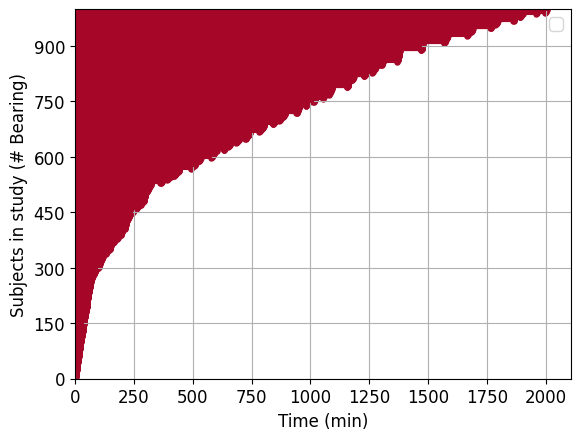

In [ ]:
from lifelines.plotting import plot_interval_censored_lifetimes

ax = plot_interval_censored_lifetimes(data_X['Survival_time'], data_X['Survival_time'])
plt.xlabel("Time (min)")
plt.ylabel("Subjects in study (# Bearing)")
plt.legend()
# plt.legend(surv_label)
plt.grid()

There are 100 samples censored from a total of 1000 samples
10.0% of records are censored


<Figure size 900x600 with 0 Axes>

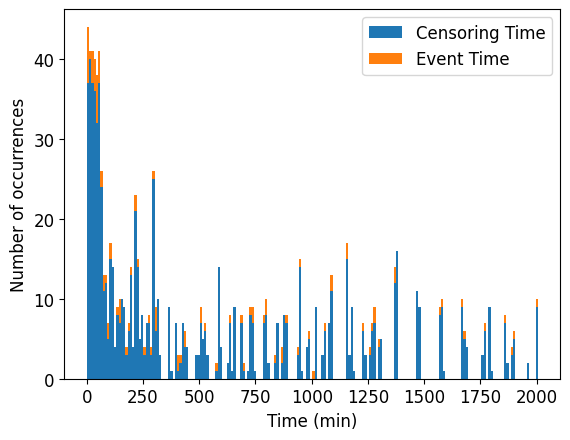

<Figure size 900x600 with 0 Axes>

In [ ]:
n_censored = data_X.shape[0] - data_X["Event"].sum()
print ("There are {} samples censored from a total of {} samples".format(n_censored, data_X.shape[0]))
print("%.1f%% of records are censored" % (n_censored / data_X.shape[0] * 100))

val, bins, patches = plt.hist((data_X["Survival_time"][data_X["Event"]],
                                data_X["Survival_time"][~data_X["Event"]]),
                                bins=200, stacked=True)
_ = plt.legend(patches, ["Censoring Time", "Event Time"])
plt.xlabel("Time (min)")
plt.ylabel("Number of occurrences")
plt.figure(figsize=(9, 6))